In [1]:
import pandas as pd
import sqlite3
import re

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import pipeline
#import torch

tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [2]:
con = sqlite3.connect('data.db')

cur = con.cursor()

articles = [*cur.execute("select * from article;")]
companies = [*cur.execute("select * from company;")]
a2c = [*cur.execute("select * from article_company;")]

con.close()

In [3]:
articles = pd.DataFrame(articles, columns=['idx', 'title', 'text', 'href', 'date']).set_index('idx')
a2c = pd.DataFrame(a2c, columns=['article_id', 'company_id'])
companies = pd.DataFrame(companies, columns=['idx', 'name', 'ticker']).set_index('idx')

In [4]:
articles['text_size'] = articles['text'].apply(lambda x: len(x.split()))
articles['date'] = pd.to_datetime(articles['date'], infer_datetime_format=True)

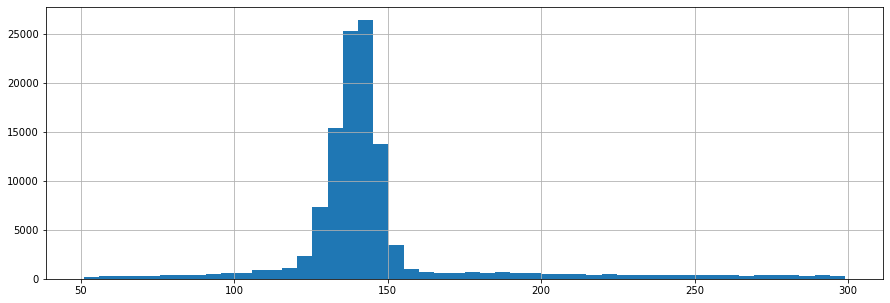

In [5]:
mask = articles['date'] > '2018-01-01'
articles = articles[mask]

mask = articles['text_size'] > 50
articles = articles[mask]
mask = articles['text_size'] < 300
articles = articles[mask]

articles['text_size'].hist(bins=50, figsize=(15,5));

In [6]:
easy_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [21]:
articles['title_sentiment'] = articles['title'].apply(easy_sentiment)

In [22]:
articles['text_sentiment'] = articles['text'].apply(easy_sentiment)

Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (696) must match the size of tensor b (512) at non-singleton dimension 1

In [23]:
articles.head()

,title,text,href,date,text_size,title_sentiment
idx,,,,,,
1,3M Co. stock outperforms market on strong trad...,Shares of 3M Co. inched 0.92% higher to $199.2...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-10,137,"[{'label': 'negative', 'score': 0.756010472774..."
2,"3M Co. stock falls Monday, underperforms market","Shares of 3M Co. shed 0.35% to $197.43 Monday,...",https://www.marketwatch.com/story/3m-co-stock-...,2021-08-09,144,"[{'label': 'negative', 'score': 0.967450439929..."
3,"3M Co. stock rises Friday, still underperforms...",Shares of 3M Co. inched 0.17% higher to $198.1...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-06,148,"[{'label': 'positive', 'score': 0.562066197395..."
4,"3M Co. stock rises Thursday, still underperfor...",Shares of 3M Co. inched 0.14% higher to $197.8...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-05,137,"[{'label': 'negative', 'score': 0.499814897775..."
5,3M Co. stock underperforms Wednesday when comp...,Shares of 3M Co. slid 1.74% to $197.53 Wednesd...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-04,133,"[{'label': 'negative', 'score': 0.959343969821..."


In [24]:
articles.to_json('articles_with_sentiment.json')

In [25]:
df = pd.read_json('articles_with_sentiment.json')
df.head()

,title,text,href,date,text_size,title_sentiment
1,3M Co. stock outperforms market on strong trad...,Shares of 3M Co. inched 0.92% higher to $199.2...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-10,137,"[{'label': 'negative', 'score': 0.7560104728}]"
2,"3M Co. stock falls Monday, underperforms market","Shares of 3M Co. shed 0.35% to $197.43 Monday,...",https://www.marketwatch.com/story/3m-co-stock-...,2021-08-09,144,"[{'label': 'negative', 'score': 0.9674504399}]"
3,"3M Co. stock rises Friday, still underperforms...",Shares of 3M Co. inched 0.17% higher to $198.1...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-06,148,"[{'label': 'positive', 'score': 0.5620661974}]"
4,"3M Co. stock rises Thursday, still underperfor...",Shares of 3M Co. inched 0.14% higher to $197.8...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-05,137,"[{'label': 'negative', 'score': 0.4998148978}]"
5,3M Co. stock underperforms Wednesday when comp...,Shares of 3M Co. slid 1.74% to $197.53 Wednesd...,https://www.marketwatch.com/story/3m-co-stock-...,2021-08-04,133,"[{'label': 'negative', 'score': 0.9593439698}]"


In [27]:
articles.loc[1,'title_sentiment'] == df.loc[1,'title_sentiment']

False